# Fine-tune the transformer model with LoRA

In [ ]:
!pip install wordcloud seaborn transformers datasets

## 1. Dataset download

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from wordcloud import WordCloud,STOPWORDS
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset, concatenate_datasets

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
imdb = load_dataset("imdb")
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Repartition the dataset

In [3]:
all_data = concatenate_datasets([imdb['train'], imdb['test']])

train_data = all_data.select(range(0, 35000))
valid_data = all_data.select(range(35000, 40000))
test_data = all_data.select(range(40000, 50000))

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(valid_data)}")
print(f"Test size: {len(test_data)}")

Train size: 35000
Validation size: 5000
Test size: 10000


In [4]:
# save to disk
train_data.to_csv("./data/train-liam.csv")
valid_data.to_csv("./data/val-liam.csv")
test_data.to_csv("./data/test-liam.csv")

Creating CSV from Arrow format:   0%|          | 0/35 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

13053070

## 2. Exploratory Data Analysis

In [5]:
train_df = pd.read_csv("./data/train-liam.csv")
train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    35000 non-null  object
 1   label   35000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 547.0+ KB


In [7]:
train_df.label.value_counts().to_frame()

,count
label,
0,22500
1,12500


In [8]:
train_df['text_length'] = train_df.text.str.split().apply(len)
train_df.head()

,text,label,text_length
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214
2,If only to avoid making this type of film in t...,0,93
3,This film was probably inspired by Godard's Ma...,0,118
4,"Oh, brother...after hearing about this ridicul...",0,311


In [9]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1,
    color_codes=True, rc=None,
)

def word_length(df, label_name, labels, text_length):
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121)
    sns.histplot(df[df[label_name]==labels[1]][text_length], ax=ax1, color='green')
    describe = df[text_length][df[label_name]==labels[1]].describe().to_frame().round(2)
    ax1.set_title('Positive')

    ax2 = fig.add_subplot(122)
    sns.histplot(df[df[label_name]==labels[0]][text_length], ax=ax2,color='red')
    describe = df[text_length][df[label_name]==labels[0]].describe().to_frame().round(2)
    ax2.set_title('Negitive')

    plt.show()

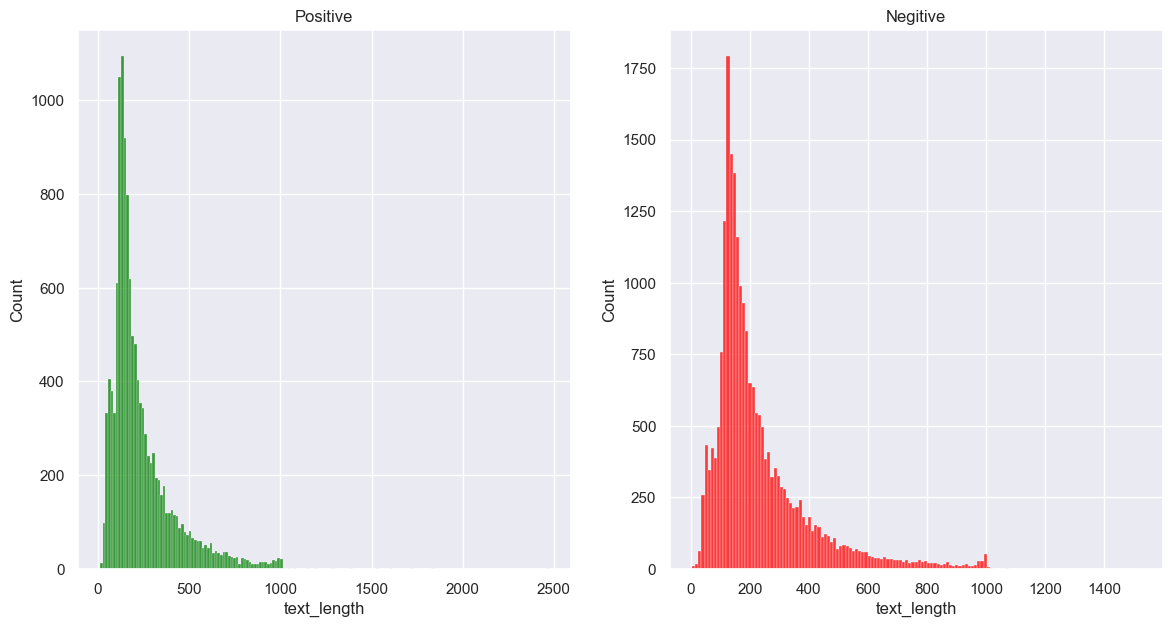

In [10]:
# Distribution of text length for positive / negitive
word_length(train_df, 'label', [0, 1], 'text_length')

In [11]:
# Distribution of text length
train_df['text_length'].describe().to_frame()

,text_length
count,35000.000000
mean,232.487457
std,171.163200
min,4.000000
25%,127.000000
50%,174.000000
75%,282.250000
max,2470.000000


In [12]:
# get length of words which covers 90% of data, we'll still take 512 length!
np.percentile(train_df['text_length'], 90)

452.0

In [13]:
# Show positive samples
pd.set_option('display.max_colwidth', None)
train_df.query('label==1').query('text_length<200').sample(5)

,text,label,text_length
12770,"Absolutely one of my favorite movies of all time. I have seen it at least a hundred times and I can't go through it without crying. I defy anyone to watch the reunion of Celie and Nettie, or Shug and father and not feel your eyes getting misty. Whoopie Goldberg should have one an award for amazing portrayal. And for the person who said you can't love the movie if you loved the book, wrong! Im a testament to that.",1,80
24175,"Tripping Over. I must say at first I was a little disappointed in the first few episodes, but having faith in the show, and Abe Forsythe's unquestionable talent, I continued to watch. I can safely say I'm now glad that I did. The story did develop quite well, and all the characters have a strong base, and most don't have any information missing.<br /><br />The only thing I can fault in this production is the somewhat annoying voice and pronunciation possessed by the character Lizzie.<br /><br />Some good acting coupled with a stellar plot really gets this show over the line. Here's to hoping for another season!",1,107
23302,"I watched the movie in a preview and I really loved it. The cast is excellent and the plot is sometimes absolutely hilarious. Another highlight of the movie is definitely the music, which hopefully will be released soon. I recommend it to everyone who likes the British humour and especially to all musicians. Go and see. It's great.",1,58
13676,"This is a very good movie. Do you want to know the real reasons why so many here are knocking this movie? I will tell you. In this movie, you have a black criminal who outwits a white professor. A black cop who tells the white professor he is wrong for defending the black criminal and the black cop turns out to be right, thus. making the white professor look stupid. It always comes down to race. This is an excellent movie. Pay no attention to the racist. If you can get over that there are characters who are played by blacks in this movie who outsmart the white characters, then you shouldn't have any problems enjoying this movie. I recommended everyone to go see this movie.",1,127
13389,"i think it is a nice movie; i think it is a very romanian movie through scenery and atmoshpere; i think it was not intended to be sensual (sensuality is a result, not a purpose); i think it is very natural; i think it is humane; i think it was interesting; i think the actors never made me think... waw lame acting (they are not Sean Connory & co) neither is the film a block buster, they are like the movie... normal ppl that can act...; i think the movie reached its intention; i think it made me feel things (or feel them again :) ); i think i'm not objective;<br /><br />i really enjoyed it... that i know.",1,119


In [14]:
#word cloud for positive review words
def word_cloud(texts):
    plt.figure(figsize=(10,10))
    WC = WordCloud(width=1000, height=500, max_words=3000, min_font_size=5)
    words = WC.generate(text=texts)
    plt.imshow(words, interpolation='bilinear')

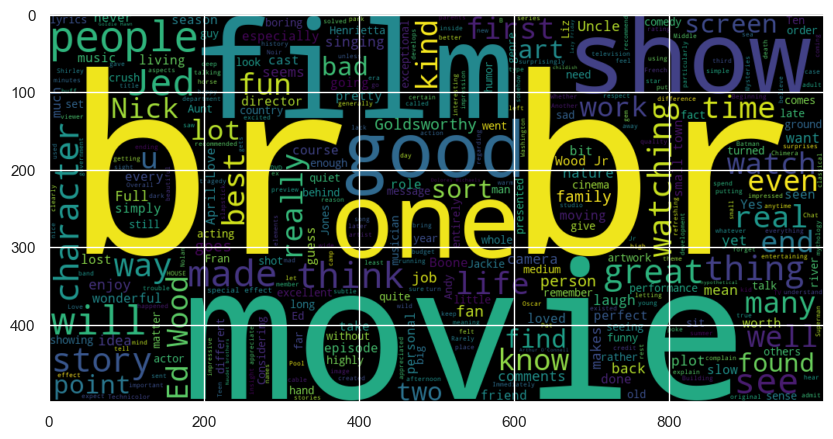

In [15]:
positive_text = ' '.join(train_df.query('label == 1').sample(20)['text'])
word_cloud(positive_text)

In [16]:
pd.set_option('display.max_colwidth', None)
train_df.query('label==0').query('text_length<200').sample(5)

,text,label,text_length
1272,"Some movies are repellent but still fascinating (Pulp Fiction); others are simply boring. This movie has an almost unique feature of being both utterly repellent and totally boring. By the end I didn't care about any of the characters, I just wanted all of them dead so I could get out of the theatre.",0,54
25506,"This movie includes 2 well known actors I have previously enjoyed watching. There actions are great and each action is heart felt. But it makes me think these 2 were thrown into a speech/drama class at college for the first time and told for one to act dominating and constricting to the other in a room without allowing her to leave and the woman to be truly innocent and treat her with enough mind-humping to drive the audience into tears for her release.<br /><br />The only good part IS the acting abilities, the plot has the same ruse as Hitlers influence and I started to hate the protagonist for that. But all of this could have been done within 15 minutes in my opinion, so to drag it out for over an hour was just pure punishment for all who watched it.<br /><br />",0,144
34650,"How this film could be classified as Drama, I have no idea. If I were John Voight and Mary Steenburgen, I would be trying to erase this from my CV. It was as historically accurate as Xena and Hercules. Abraham and Moses got melded into Noah. Lot, Abraham's nephew, Lot, turns up thousands of years before he would have been born. Canaanites wandered the earth...really? What were the scriptwriters thinking? Was it just ignorance (""I remember something about Noah and animals, and Lot and Canaanites and all that stuff from Sunday School"") or were they trying to offend the maximum number of people on the planet as possible- from Christians, Jews and Muslims, to historians, archaeologists, geologists, psychologists, linguists ...as a matter of fact, did anyone not get offended? Anyone who had even a modicum of taste would have winced at this one!",0,143
30790,"I saw this film last night, a satire of the reality style programs that seem to be making the rounds at the moment.<br /><br />What can I say. I absolutely hated it. About as interesting as watching paint dry and with maybe one or two only slightly amusing moments.<br /><br />Maybe it had something to do with me definately not being a fan of the Survivor and Big Brother type shows, but if this had been a video/DVD or if I'd been watching at the cinema on my own I would have definately not endured more than the first 5 minutes.<br /><br />",0,103
208,"I watched Cabin by the Lake this afternoon on USA. Considering this movie was made for TV is was interesting enough to watch the sequel. So, I tune in for the airing this evening and was extremely disappointed. I knew I wouldn't like the movie, but I was not expecting to be perplexed by the use of DV (digital video). The movie would have been tolerable if it wasn't for these juxtaposed digital shots that seemed to come from nowhere. I expected the plot line to be tied in with these shots, but there seemed to be no logical explanation. (WARNING: THE FOLLOWING MAYBE A SPOILER!!!!) The open ending in Cabin by the Lake was acceptable, but the open ending on the sequel is ridiculous. I can only foresee Return of Return to The Cabin by the Lake being watch able is if the movie was shown up against nothing, but infomercials at 4 o'clock in the morning.",0,158


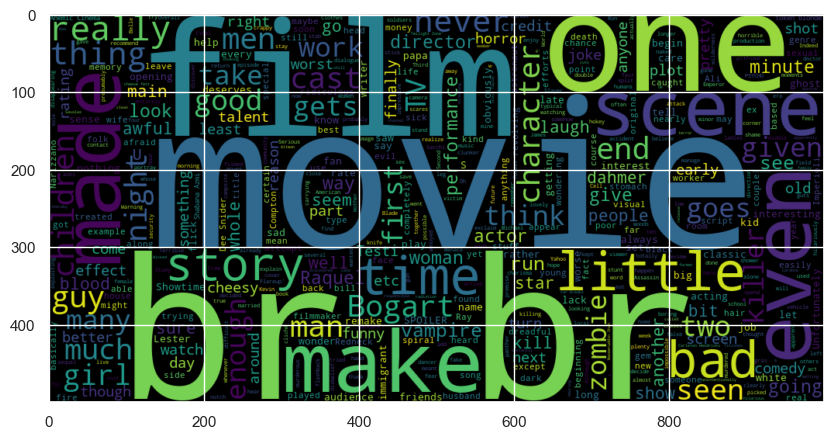

In [18]:
negitive_text = ' '.join(train_df.query('label == 0').sample(20)['text'])
word_cloud(negitive_text)

## 3. Base model choosing
- https://huggingface.co/distilbert/distilbert-base-uncased

In [19]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## 4. Coding LoRA from Scratch

In [117]:
# Freeze all layers of the model
for param in model.parameters():
    param.requires_grad = False

In [119]:
# Create LoRA layer
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.W_a = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.W_b = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
        
    def forward(self, x):
        x = self.alpha * (x @ self.W_a @ self.W_b)
        return x
    
class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
        
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [121]:
# Add LoRA layers
lora_r = 8
lora_alpha = 16
lora_query = True
lora_key = False
lora_value = True
lora_projection = False
lora_mlp = False
lora_head = False

layers = []
assign_lora = partial(LinearWithLoRA, rank=lora_r, alpha=lora_alpha)

for layer in model.distilbert.transformer.layer:
    if lora_query:
        layer.attention.q_lin = assign_lora(layer.attention.q_lin)
    if lora_key:
        layer.attention.k_lin = assign_lora(layer.attention.k_lin)
    if lora_value:
        layer.attention.v_lin = assign_lora(layer.attention.v_lin)
    if lora_projection:
        layer.attention.out_lin = assign_lora(layer.attention.out_lin)
    if lora_mlp:
        layer.ffn.lin1 = assign_lora(layer.ffn.lin1)
        layer.ffn.lin2 = assign_lora(layer.ffn.lin2)
        
if lora_head:
    model.pre_classifier = assign_lora(model.pre_classifier)
    model.classifier = assign_lora(model.classifier)

In [122]:
# Show new model structure
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): LinearWithLoRA(
              (linear): Linear(in_features=768, out_features=768, bias=True)
              (lora): LoRALayer()
            )
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): LinearWithLoRA(
              (linear): Linear(in_features=768, out_features=768, bias=True)
              (lora): LoRALayer()
            )
            (out_lin): Linear(in_features=768, out_features=768, bias

In [123]:
# Count parameters of the model
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    for p in model.parameters():
        total_params += p.numel()
        if p.requires_grad:
            trainable_params += p.numel()
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)
print("Total number of parameters: ", total_params)
print(f"Number of trainable parameters: {trainable_params} ({trainable_params/total_params*100:.2f}%)")

Total number of parameters:  67102466
Number of trainable parameters: 147456 (0.22%)


## 5. Fine-tune

## 6. Test

In [136]:
test_df = pd.read_csv("./data/test-liam.csv")

In [140]:
pd.set_option('display.max_colwidth', None)
test_df.query('label==1').sample(5)

,text,label
3229,Giorgino can to some people look a bit long but it's one of rare real romantique adventure film. It could be compare to Docter Jivago with a bit of Sleepy Holow. You must see it.,1
5614,"My friend took me to a screening of this movie in Hollywood and it was awesome! It's a film noir with amazing acting, great script, cool music, the whole thing was very well done and entertaining. Don't know if it is getting a release in theaters, but this would be a great date movie or a fun movie to rent if you see it at Blockbuster. This is the kind of movie I love, low on budget but big on style and imagination. I hope Alexandra Holden gets more big parts like she has in this one, she is fantastic.",1
8285,"The Andrew Davies adaptation of the Sarah Waters' novel was excellent. The characters of Nan and and Kitty were superbly portrayed by Rachael Stirling and Kelley Hawes respectively. The whole series was a total joy to watch. It caught the imagination of everyone across the board, whether straight or gay. I wish there could be a sequel!",1
4949,"This is the first Pepe Le Pew cartoon and in some ways it's very similar to the later ones but in a few other odd ways it is not. While the object of Pepe's affections IS a cat, oddly it appears to be a BOY cat! This whole predicament occurs because a cat is tired of being abused by others and dresses up like a skunk and tries to smell like a skunk so it can be left alone. Unfortunately, this attracts our hero, Pepe. Most of the action is pretty typical until the very funny and unexpected ending--and this actually makes this one of the best of all cartoons in the series. Excellent animation (though the style is different than later examples), excellent writing and a good sense of humor make this one a keeper.",1
5720,"One of my absolute favorite childhood films. The Chipmunk adventure packs incredible fun geared for young and old alike. The animation is lively and colorful and the film itself boasts some of the best songs ever put in an animated feature. Who could forget the dynamic ""Boys/Girls of Rock n' Roll"", the exciting ""Diamond Dolls"", and the heartrending ""My Mother""? <br /><br />This should be considered a nostalgic classic animated gem from the eighties. It's too bad they don't make them like this anymore. Most animated films today resort to violence, crude humor, or sentimental mush... except of course the folks from Pixar.<br /><br />BOTTOM LINE: An amazing and unforgettable adventure for all ages.",1
